
# CSD  de Actividad Evocada. 
Usemos esto como opurtunidad para poner todo el código en orden.


En este *notebook* de Julia implementaremos métodos numéricos para llevar a cabo un análisis de *densidad de fuentes y pozos de corriente* sobre una rebanada del hipocámpo de una rata. En este Notebook estudiaremos los datos de los experimentos evocados que hizo Franco en Agosto. La parte de CM la dejaremos en el siguiente Notebook.
 Al parecer primero toca hacer una prueba con todo aquí mismo antes que hacer un modulo ordenado por una inconveniencia al hacer modulos (no se pueden recargar).

Los siguientes módulos son para trabajar los datos y hacer gráficas. HDF5 es el formato de los datos en "\*.brw", gloriosamente. Son diccionarios que tienen las variables indicadas en la función de AbreyCheca.  

In [1]:
using HDF5
using JLD
using PyPlot
matplotlib[:rcParams][:"svg.image_noscale"]=false

false

In [2]:
function AbreyCheca(x::AbstractString)
    #Abre el archivo de brw (acepta el nombre tal cual)
    archivo=h5open(x)
    #sacatito todas las variables que te interesan
    numcuadros=archivo["/3BRecInfo/3BRecVars/NRecFrames"][1][1]
    frecuencia=archivo["/3BRecInfo/3BRecVars/SamplingRate"][1][1]
    maxvolt=archivo["/3BRecInfo/3BRecVars/MaxVolt"][1][1]
    minvolt=archivo["/3BRecInfo/3BRecVars/MinVolt"][1][1]
    bitdepth=archivo["/3BRecInfo/3BRecVars/BitDepth"][1][1]
    duracionexperimento=numcuadros/frecuencia
    factordeescala=(maxvolt-minvolt)/2^bitdepth
    DatosCrudos=read(archivo["/3BData/Raw"])
    result=Dict("numcuadros" => numcuadros,
                "frecuencia"=> frecuencia,
                "maxvolt" => maxvolt,
                "minvolt" => minvolt,
                "bitdepth" => bitdepth,
                "duracion" => duracionexperimento,
                "factor" => factordeescala,
                "DatosCrudos"=>DatosCrudos )
    return result
                    
end

AbreyCheca (generic function with 1 method)

In [99]:
Datos=AbreyCheca("/media/discogrande/estimulacion_control2/est2_con2.brw")
#Este string es para guardar los datos con un nombre útil
StringDatos="Est2_ConV3"

"Est2_ConV3"

In [100]:
#Hay algo raro en el archivo 3R5. Por alguna razón los datos NO estan en array pero en una mugre lista
DatosCrudosArreglados=reshape(Datos["DatosCrudos"], (4096, Datos["numcuadros"]));
#DatosCrudosArreglados=Datos["DatosCrudos"]
freq=Datos["frecuencia"]/1000


17.85550205219098

In [77]:
function EncuentraTrancazosRaw(datos::Array, tolerancia=1400)
    result=Int[]
    longitud=length(datos)
    jcomp=0
    media=mean(datos)
    for j=1:longitud
        if abs(datos[j]-media)>tolerancia
            if j-jcomp>1
                push!(result,j)
            end
            jcomp=j
        end
    end
    return result
end

EncuentraTrancazosRaw (generic function with 2 methods)

In [101]:
exemplo=vec(DatosCrudosArreglados[1500,:]);

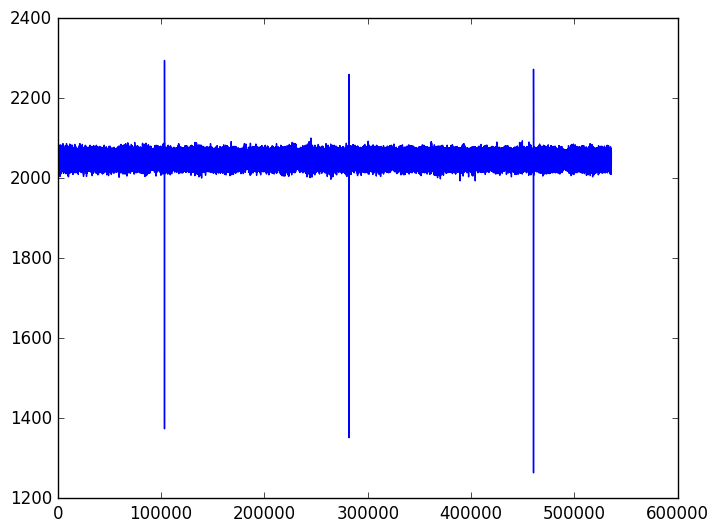

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f22e4f10f98>

In [102]:
ion()
plot(1:Datos["numcuadros"],exemplo)

In [104]:
listongas=EncuentraTrancazosRaw(exemplo,500)

3-element Array{Int64,1}:
 103249
 281806
 460363

Rafael sugiere tomar $5ms$ antes del estímulo y unos $60ms$ después. En cuadros esto resulta ser unos $5 \cdot freq$ cuadros antes y $60\cdot freq$ después. $freq$ está en cuadros por milisegundo!

In [82]:
function ActivAlrededorTrancazo(Lista::Array, xxs::Array)
    #Aqui no se le ha hecho reshape a las matrices todavia
    result=Dict{AbstractString, Array}()
    q=1
    desde=round(Int, ceil(5*freq))
    hasta=round(Int, ceil(60*freq))
    for j in Lista
        nomineclave="Trancazo_$q"
        result[nomineclave]=xxs[:,j-desde:j+hasta]
        #println(nomineclave)
        q+=1
    end
    return result
end

function ActividadFueraTrancazo(Lista::Array, xxs::Array)
    q=1
    desde=round(Int, ceil(5*freq))
    hasta=round(Int, ceil(30*freq))
    aux=trues(xxs)
    for j in Lista
        aux[j-desde:j+hasta]=false
    end
    result=zeros(1)
    aux2=find(aux)
    for j in aux2
        result=vcat(result,xxs[j])
    end
    return result
end
        

ActividadFueraTrancazo (generic function with 1 method)

In [105]:
ActividadRaw=ActivAlrededorTrancazo(listongas, DatosCrudosArreglados)
(bla,tmax)=size(ActividadRaw["Trancazo_1"])

(4096,1163)

In [84]:
factor=Datos["factor"]
function FormaMatrizDatosCentrados(xxs::Array)
    #El array tiene que ser de 4096 por algo mas
    irrrelevante,largo=size(xxs)
    aux=Array(Int32, 64,64, largo);
    for j=1:64,k=1:64
        aux[k,j,:]=xxs[j+(k-1)*64,:]
    end
    result=(aux*(-1)+2048)*factor;
    aux=0
    return result
end

FormaMatrizDatosCentrados (generic function with 1 method)

In [106]:
FueraTrancazo=ActividadFueraTrancazo(listongas,exemplo);
FueraTrancazo=(FueraTrancazo*(-1)+2048)*factor;


Hay un montonal de canales que por la forma en que requiere ser hecho el experimento no detectaron nada o casi nada. Esos aparecen el registro como saturados en el máximo valor posible. Dado que esto es MUY inconveniente para el cálculo del CM, tenemos que detectarlos automáticamente y ponerlos en cero o ver si los esquivamos.

In [107]:
DatosCentrados=Dict{AbstractString, Array}()
for k in keys(ActividadRaw)
    DatosCentrados[k]=FormaMatrizDatosCentrados(ActividadRaw[k])
end

In [108]:
function BuscaSaturados(datos::Array, saturavalue=1900)
    (ancho,alto,largo)=size(datos)
    result=Set{Array{Int,1}}()
    arreglostd=zeros(ancho,alto)
    arregloprom=zeros(ancho,alto)
    for j=1:ancho, k=1:alto
        prom=mean(datos[k,j,:])
        arregloprom[k,j]=prom
        desviacion=std(datos[k,j,:])
        arreglostd[k,j]=desviacion
        if abs(prom)>saturavalue # || desviacion<1
            push!(result, [k,j])
        end
    end
    return (result,arreglostd, arregloprom)
end

BuscaSaturados (generic function with 2 methods)

Buscar la respuesta de potencial debe ser suficiente tiempo después del trancazo. Dado que estamos apartando aprox 5ms antes del golpe y unos 35 después, tenemos que saltarnos la parte de mayor influencia de la descarga evocada, eso será el parámetro $tiemponincial$, aproximadamente unos 6.5ms desde el inicio del intervalo o 1.5ms despues del golpe. Gisela sugiere que incluso más, tal vez 3 o 4 ms

In [109]:
#Tiempo de espera despues del golpe para respuestas evocadas
tiempopostgolpe=round(Int,ceil(6.5*freq))
#Los dos umbrales son: el umbral de Actividad, y el umbral de saturacion... si un canal esta por debajo del segundo,
# es probable que este saturado.
function BuscaCanalRespActPot(datos::Array, tini=tiempopostgolpe, umbral=-200, umbralsaturacion=-1500)
    #Busquemos los canales con probable respuesta de potencial de accion
    (ancho,alto,largo)=size(datos)
    datosaux=datos[:,:,tini:largo] #fuera de la accion maxima del potencial de accion.
    #tiempos post golpe para ver si el canal esta pegado en un valor
    taux1=round(Int, ceil(0.5*freq))
    taux2=round(Int,ceil(8*freq))
    desviacionpostgolpe=std(datosaux[taux1:taux2])
    result=Set{Array{Int,1}}()
    for j=1:ancho, k=1:alto
        fondo=minimum(vec(datosaux[k,j,:]))
        if fondo<umbral && fondo>umbralsaturacion &&desviacionpostgolpe>10
            push!(result,[k,j])
        end
    end
    return result
end

BuscaCanalRespActPot (generic function with 4 methods)

In [110]:
tiempopostgolpe

117

In [123]:
PruebaRespuesta=BuscaCanalRespActPot(DatosCentrados["Trancazo_3"],120,-250)
for q in PruebaRespuesta
    x=q[2]
    y=q[1]
   # if x != 1 && y !=1  && x<47
        println(x," ", y)   
    #end
end

48 40


In [122]:
numeroderespondentes=length(PruebaRespuesta)

0

In [97]:
round(Int, ceil(5*freq)),round(Int, ceil(60*freq)),round(Int, ceil(1.5*freq))

(36,422,11)

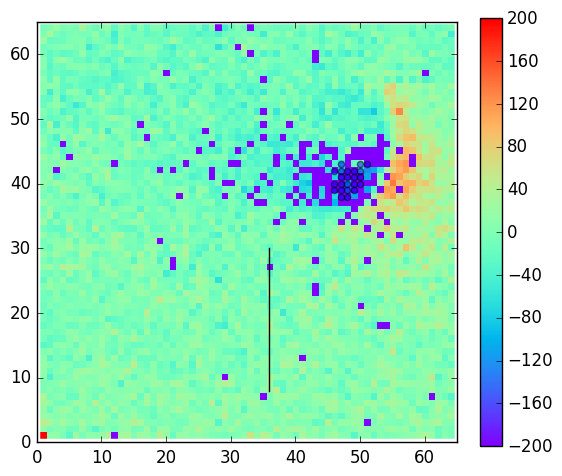

PyObject <matplotlib.collections.PathCollection object at 0x7f22e639f748>

In [119]:
figure(figsize=(6,6))
xlim(0,65)
ylim(0,65)
limites=200
exdesaturado=DatosCentrados["Trancazo_3"][:,:,140];
imagen=imshow(exdesaturado, origin="lower", interpolation="nearest", cmap="rainbow", 
vmin=-limites,vmax=limites, extent=[0.5,64.5,0.5,64.5])
plot([36, 36], [30, 8], "k-")
cb=colorbar(imagen, fraction=0.046)
xxs=zeros(numeroderespondentes)
yys=zeros(numeroderespondentes)
j=1
for q in PruebaRespuesta
    xxs[j]=q[2]
    yys[j]=q[1]
    j+=1
end
scatter(xxs,yys, alpha=0.5)   

23


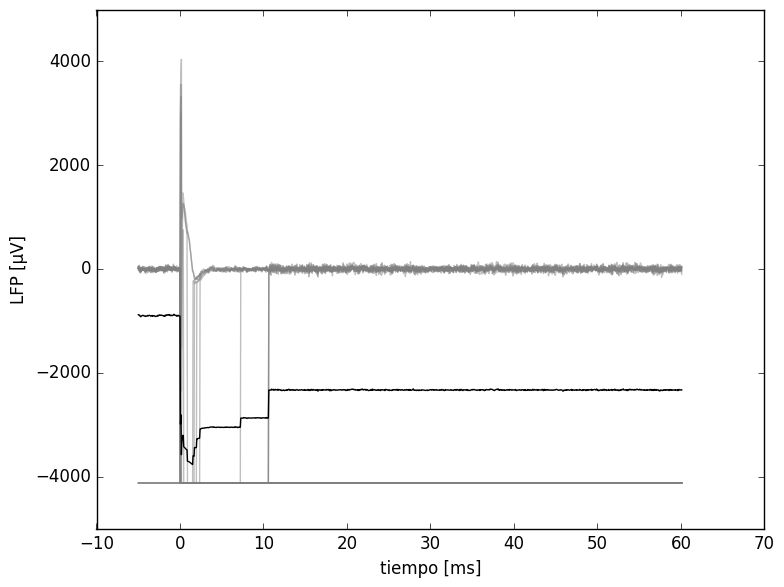

In [115]:
figure(figsize=(8,6))
xlim(-10,70)
limites=800
#ylim(-limites,limites)
thewholefockenevent=[]
#exdesaturado=DatosCentrados["Trancazo_2"][:,:,140];
#imagen=imshow(exdesaturado, origin="lower", interpolation="nearest", cmap="rainbow", vmin=-limites,vmax=limites)
promedio=zeros(tmax)
k=0
desde=round(Int, ceil(5*freq))
tiemporeal=map(x->(x-desde)/freq,1:tmax)
for q in PruebaRespuesta
    x=q[2]
    y=q[1]
    if x != 1 && y != 1 && x>45 
    k+=1
    datos=vec(DatosCentrados["Trancazo_3"][y,x,1:tmax])
        thewholefockenevent=vcat(thewholefockenevent,datos)
    promedio+=datos
 
        plot(tiemporeal, datos, c="grey", alpha=0.5)   
    end
end
promedio=promedio/k
plot(tiemporeal, promedio, c="black")
xlabel("tiempo [ms]")
ylabel("LFP [µV]")

tight_layout()
println(k)
outname=string("RespuestasEspantosas_",StringDatos,"-01.png")

savefig(outname, dpi=92)

In [128]:
promedio

1163-element Array{Float64,1}:
 -1574.18 
 -1641.96 
 -1582.76 
 -1642.24 
 -1678.03 
 -1579.2  
 -1638.36 
 -1667.16 
 -1648.24 
 -1592.12 
 -1589.5  
 -1645.57 
 -1590.11 
     ⋮    
  -188.722
  -246.805
  -342.032
  -206.053
  -190.502
  -244.931
  -189.846
  -174.342
  -217.342
  -254.674
  -246.945
  -181.649

In [30]:
binsize=8
HistogramaGolpes=hist(thewholefockenevent, -300:binsize:300)

(-300:8:300,[3,3,12,7,8,11,7,11,11,10  …  40,32,32,45,51,50,50,47,24,42])

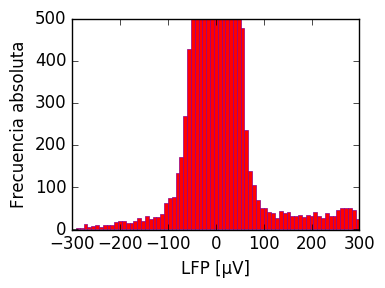

"HistogramaDisparosEvocados-3R11.png"

In [31]:
xdata=collect(HistogramaGolpes[1][2:end])
measuredata=HistogramaGolpes[2];
figure(figsize=(4,3))
xlim(-300,300)
ylim(-0.1,500)
bar(xdata,measuredata, binsize, color="red", linewidth=0.5, edgecolor="darkmagenta")
xlabel("LFP [µV]")
ylabel("Frecuencia absoluta")
tight_layout()
outname=string("HistogramaDisparosEvocados-",StringDatos,".png")
#savefig(outname,dpi=90)

In [32]:
DictSaturados=Dict{AbstractString, Tuple}()
for k in keys(DatosCentrados)
    DictSaturados[k]=BuscaSaturados(DatosCentrados[k])
end

In [33]:
function imitaruido(x::Array)
    #Esta funcion asume que x es ruido gaussiano y lo imita.
    #Igual de largo que xx
    sigma=std(x)
    prom=mean(x)
    l=length(x)
    result=sigma*randn(l)+prom
    return result
end

function hazruido(sigma, prom, length)
    # hace ruido
    result=round(Int32, sigma*randn(length)+prom)
    return result
end



hazruido (generic function with 1 method)

In [34]:
binsize=2
HistogramaRuido=hist(FueraTrancazo, -100:binsize:100)

(-100:2:100,[26,31,37,56,35,118,63,89,95,146  …  30,29,20,12,15,9,3,5,2,2])

In [35]:
sigmaruido=std(FueraTrancazo)
promruido=mean(FueraTrancazo)
(promruido,sigmaruido)

(-0.4399116716734721,28.154419011879412)

In [36]:
RuidoArtificial=imitaruido(FueraTrancazo)
HistoRuidoArtificial=hist(RuidoArtificial,-100:binsize:100)
norma=length(RuidoArtificial)
mean(RuidoArtificial),std(RuidoArtificial)


(-0.3572068335005285,28.08932410405051)

In [37]:
mu=promruido
sigma=sigmaruido
function gauss(x)
    return 1/(sqrt(2*pi)*sigma)*exp(-((x-mu)/sigma)^2/2)
end

gauss (generic function with 1 method)

In [38]:
xdata=collect(HistogramaRuido[1][2:end])
measuredata=HistogramaRuido[2];

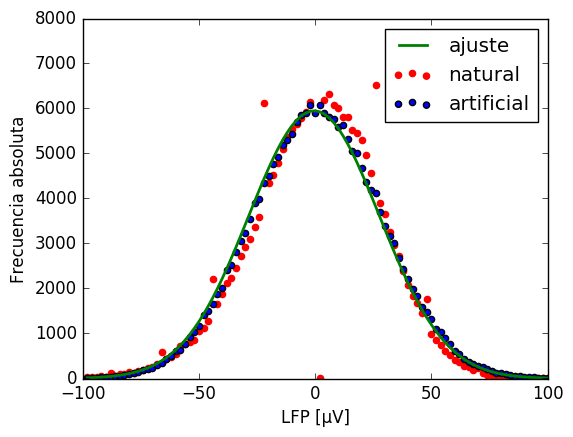

"GaussianasBonitas_3R11.png"

In [39]:
figure(figsize=(6,4.5))
xlim(-100,100)
ylim(-0.1,8000)
scatter(xdata,measuredata, color="red", label="natural")
scatter(HistoRuidoArtificial[1][2:end],HistoRuidoArtificial[2], label="artificial")
plot(xdata, map(x->binsize*norma*gauss(x),xdata), color="green",lw=2, label="ajuste")
legend()
xlabel("LFP [µV]")
ylabel("Frecuencia absoluta")
outname=string("GaussianasBonitas_",StringDatos,".png")
#savefig(outname, dpi=92)

In [40]:
function vecindad8(punto::Array)
    j=punto[1]
    k=punto[2]
    result=Set{Array{Int64,1}}()
    push!(result, [j-1,k-1])
    push!(result, [j-1,k])
    push!(result, [j-1,k+1])
    push!(result, [j,k-1])
    push!(result, [j,k+1])
    push!(result, [j+1,k-1])
    push!(result, [j+1,k])
    push!(result, [j+1,k+1])
    return result
end

function promediasobreconjunto(puntos::Set, datos::Array)
    n=0
    result=0
    for q in puntos
        result+=datos[q[1],q[2]]
        n+=1
    end
    result/=n
    return result
end
        

function TiraOrillas(Puntos::Set)
    result=Set([])
    for p in Puntos
        if !(p[1]==1 || p[2]==1 || p[1]==64 ||  p[2]==64)
            push!(result,p)
           # println("Añadiendo ", p, " al result") 
        end
    end
    return result
end

TiraOrillas (generic function with 1 method)

In [41]:
DatosDesaturados=Dict{AbstractString, Array}()
n=0
l=0
for k in keys(DatosCentrados)
    largo=length(DatosCentrados[k][1,1,:])
    lista=DictSaturados[k][1]
    aux=copy(DatosCentrados[k])
   # println(k," ",length(lista))
    
     for m in lista

        q=m[1]
        p=m[2]
        aux[q,p,:]=hazruido(sigmaruido,promruido,largo)
        n+=1
     end
    
    listaredux=TiraOrillas(lista)
    
    for m in listaredux

        q=m[1]
        p=m[2]
        vecinos=vecindad8(m)
        aux[q,p,:]=promediasobreconjunto(vecinos,aux)
        n+=1
     end

    
    
    DatosDesaturados[k]=aux
end
print(n,", ",l)

892, 0

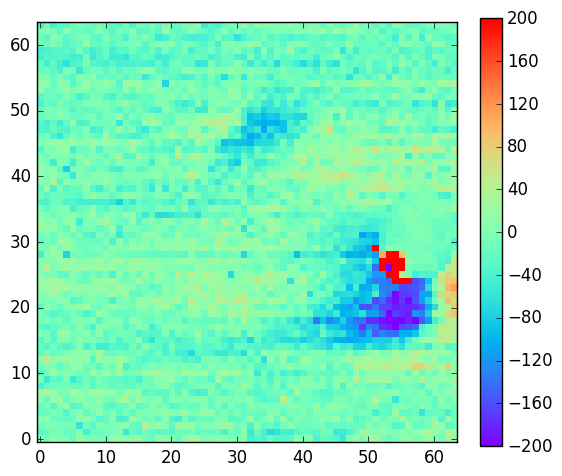

"LFP_Limpiado_3R11.svg"

In [42]:
ion()
limites=200
figure(figsize=(6,6))

exdesaturado=DatosDesaturados["Trancazo_2"][:,:,140];
imagen=imshow(exdesaturado, origin="lower", interpolation="nearest", cmap="rainbow", vmin=-limites,vmax=limites)
cb=colorbar(imagen, fraction=0.046)
outname=string("LFP_Limpiado_",StringDatos,".svg")
#savefig(outname, dpi=96)

In [49]:
outname=string("LFP_Desaturado_",StringDatos,".jld")
save(outname, "LFPDenoized", DatosDesaturados, "LFPSaturados", DatosCentrados, "freq",freq)

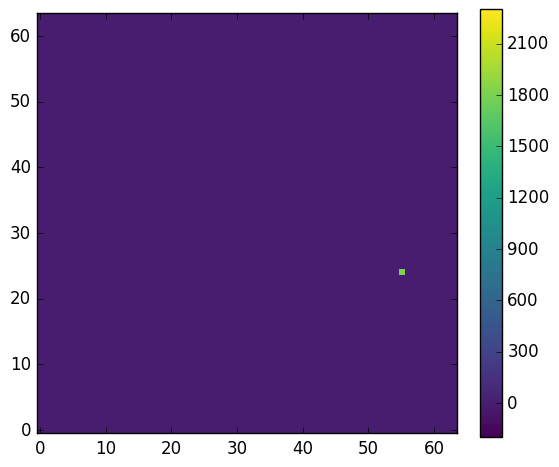

PyObject <matplotlib.colorbar.Colorbar object at 0x7f3d75ab94a8>

In [44]:
limites=2300
figure(figsize=(6,6))
rara=zeros(64,64)
exdesaturado=mean!(rara, DatosDesaturados["Trancazo_2"]);
map!(x->x>1800?x:0, exdesaturado)
imagen=imshow(exdesaturado, origin="lower", interpolation="nearest", cmap="viridis", vmin=-200,vmax=limites)
cb=colorbar(imagen, fraction=0.046)

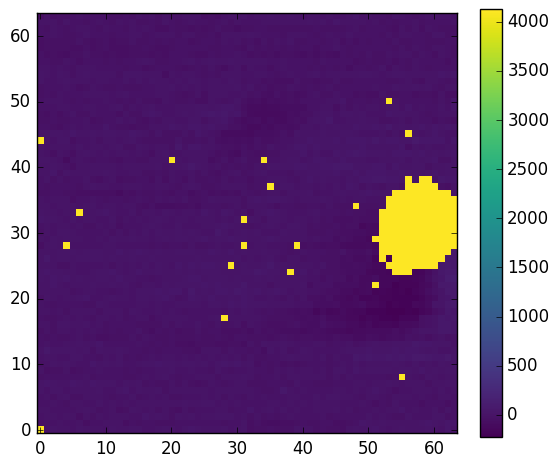

PyObject <matplotlib.colorbar.Colorbar object at 0x7f3d759f8cc0>

In [46]:
figure(figsize=(6,6))
exsaturado=DatosCentrados["Trancazo_2"][:,:,140];
imagen=imshow(exsaturado, origin="lower", interpolation="nearest", cmap="viridis")
cb=colorbar(imagen,fraction=0.046)
#savefig("LFP_Saturado_1-340.svg", dpi=96)

In [50]:
desde

36

In [51]:
PyPlot.ioff()
limites=200
for t=1:tmax 
    tau=t-desde
    milisec=round(tau/7.02, 2)   
    exdesaturado=DatosDesaturados["Trancazo_2"][:,:,t];
    figure(figsize=(6,6))
    imagen=imshow(exdesaturado, origin="lower", interpolation="nearest", vmin=-limites,vmax=limites, cmap="jet")
    cb=colorbar(imagen, fraction=0.046)
    PyPlot.title("t= $milisec ms")
    outname=string("LFP_Desaturado_2_",StringDatos,"-$t.png")
    savefig(outname, dpi=96)
    close()
end

LoadError: LoadError: PyError (:PyObject_Call) <class 'TypeError'>
TypeError('Object does not appear to be a 8-bit string path or a Python file-like object',)
  File "/usr/lib64/python3.4/site-packages/matplotlib/pyplot.py", line 688, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/usr/lib64/python3.4/site-packages/matplotlib/figure.py", line 1565, in savefig
    self.canvas.print_figure(*args, **kwargs)
  File "/usr/lib64/python3.4/site-packages/matplotlib/backend_bases.py", line 2232, in print_figure
    **kwargs)
  File "/usr/lib64/python3.4/site-packages/matplotlib/backends/backend_agg.py", line 537, in print_png
    _png.write_png(renderer._renderer, filename_or_obj, self.figure.dpi)

while loading In[51], in expression starting on line 3

In [52]:
function UnNormGauss(x,sigma)
    return exp(-x*x/(2*sigma))
end

function GaussSuavizarTemporal(Datos,Sigma=3)  
    #sigma esta medido en pixeles, es la desviacion estandar de nuestro kernel.
    #El medioancho de nuestra ventana seran 3*sigma
    #Esto es escencialmente un filtro pasabajos
    medioancho=ceil(Sigma*3)
    colchon=ones(medioancho)
    result=zeros(Datos)
    datoscolchon=vcat(colchon*Datos[1], Datos, colchon*Datos[end])
    kernel=map(x->UnNormGauss(x,Sigma), collect(-medioancho:medioancho))
    kernel=kernel/(sum(kernel))
    #La convolucion asi normalizada preserva el valor RELATIVO entre los puntos de la funcion.
    #pero queremos ponerlo mas parecido a los voltajes que medimos, para preservar el rango de valores
    #experimentales y su criterio de potenciales de accion / ruido
    for t=medioancho+1:length(Datos)+medioancho
        result[t-medioancho]=sum(datoscolchon[t-medioancho:t+medioancho].*kernel)
    end
    a=maximum(abs(Datos))
    b=maximum(abs(result))
    #nromalizacion 
    #result=result*a/b
    return result
end   

GaussSuavizarTemporal (generic function with 2 methods)

In [53]:
#De momento todo "in file"
GaussianKernel=[0.00000067	0.00002292	0.00019117	0.00038771	0.00019117	0.00002292	0.00000067
0.00002292	0.00078634	0.00655965	0.01330373	0.00655965	0.00078633	0.00002292
0.00019117	0.00655965	0.05472157	0.11098164	0.05472157	0.00655965	0.00019117
0.00038771	0.01330373	0.11098164	0.22508352	0.11098164	0.01330373	0.00038771
0.00019117	0.00655965	0.05472157	0.11098164	0.05472157	0.00655965	0.00019117
0.00002292	0.00078633	0.00655965	0.01330373	0.00655965	0.00078633	0.00002292
    0.00000067	0.00002292	0.00019117	0.00038771	0.00019117	0.00002292	0.00000067]

function GaussianSmooth(Datos)
    tamanodatos=size(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    for j=1:3
        temp=vcat(temp[1,:], temp, temp[end,:])
    end
    for j=1:3
        temp=hcat(temp[:,1], temp, temp[:,1])
    end
    
    for j=4:tamanodatos[1]+3, k=4:tamanodatos[2]+3
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-3:j+3,k-3:k+3]
        result[j-3,k-3]=sum(GaussianKernel.*aux)
    end
    #Esta convolución no respeta norma L2
    #result=result*maximum(abs(Datos))/maximum(abs(result))
    return result
end



GaussianSmooth (generic function with 1 method)

In [56]:
#checa que Julia va ordenando los datos renglon por renglon, no columna por columna
LaplacianTerm1=[[0 1 0]; [1 -4 1]; [0 1 0]]
LaplacianTerm2=[[0.5 0 0.5]; [0 -2 0]; [0.5 0 0.5]]
LaplacianKernel=(1-1/3)*LaplacianTerm1+(1/3)*LaplacianTerm2

#Nueva variante: AHORA SI VAMOS A ELIMINAR LAS ORILLAS
#Los efectos de borde estan dando puro choro en el CSD.
function DiscreteLaplacian(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    temp=vcat(temp[1,:], temp, temp[end,:])
    temp=hcat(temp[:,1], temp, temp[:,end])
    largo,ancho=size(Datos)
    aux=Array(Float64,(3,3))
    result=zeros(Datos)
    for j=2:largo-1, k=2:ancho-1
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-1:j+1,k-1:k+1]
        result[j,k]=sum(LaplacianKernel.*aux)
    end
    #DO NOT Crop the borders
    return result
end

DiscreteLaplacian (generic function with 1 method)

In [57]:
CSD=Dict{AbstractString, Array}()
for k in keys(DatosDesaturados)
    (mu,nu,lu)=size(DatosDesaturados[k])
    aux1=zeros(mu,nu,lu)
    aux2=zeros(mu,nu,lu)
    temp=map(Float64,DatosDesaturados[k])
    for t=1:lu
        aux1[:,:,t]=GaussianSmooth(temp[:,:,t])
        aux2[:,:,t]=DiscreteLaplacian(aux1[:,:,t])
    end
    CSD[k]=-aux2
end

In [58]:
CSDPlanchada=Dict{AbstractString, Array}()
for k in keys(CSD)
    (mu,nu,lu)=size(CSD[k])
    aux=zeros(mu,nu,lu)
    for j=1:mu,l=1:nu
        porromponpon=vec(CSD[k][j,l,:])
        aux[j,l,:]=GaussSuavizarTemporal(porromponpon)
    end
    CSDPlanchada[k]=aux
end

In [59]:
CSDPromedio=CSDPlanchada["Trancazo_1"]+CSDPlanchada["Trancazo_2"]+CSDPlanchada["Trancazo_3"];
CSDPromedio/=3.0;

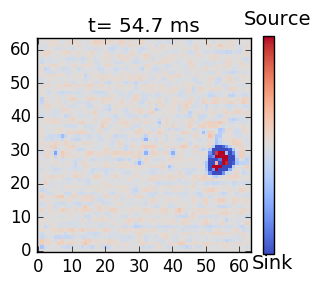

In [60]:
ion()
t=420
tau=t-36
milisec=round(tau/7.02, 2)
CSDexample=CSDPromedio[:,:,t];

figure(figsize=(3,3))
#exsaturado=DatosCentrados["Trancazo_1"][:,:,340]+DatosCentrados["Trancazo_3"][:,:,340]+DatosCentrados["Trancazo_2"][:,:,340]
imagen=imshow(CSDexample, origin="lower", interpolation="nearest", cmap="coolwarm", vmin=-40, vmax=40)
cb=colorbar(imagen,fraction=0.046, ticks=[])
 PyPlot.title("t= $milisec ms")

   
    annotate("Source",
    xy=[1.03;0.98],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
#font_properties=("DejaVu Serif"),
    fontsize=14,
    ha="left",
   va="bottom")


annotate("Sink",
    xy=[1.07;-0.16],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=14.0,
    ha="left",
    va="bottom")
    
tight_layout()  
#savefig("CSDSuave_1-$t.png", dpi=96)


In [63]:

PyPlot.ioff()
for t=1:tmax
    tau=t-36
    milisec=round(tau/7.02, 1)
    
    datos=CSDPromedio[:,:,t];
    figure(figsize=(3,3))
    imagen=imshow(datos, origin="lower", interpolation="nearest", vmin=-60,vmax=60, cmap="coolwarm")
    cb=colorbar(imagen, fraction=0.046, ticks=[])
    PyPlot.title("t= $milisec ms")
    
    annotate("Source",
    xy=[1.03;0.98],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
#font_properties=("DejaVu Serif"),
    fontsize=14,
    ha="left",
   va="bottom")


annotate("Sink",
    xy=[1.07;-0.16],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=14.0,
    ha="left",
    va="bottom")
    
    tight_layout()    
    outname=string("CSDPromedio_",StringDatos,"-$t.png")
    savefig(outname, dpi=96)
    close()
end

In [64]:
outname=string("CSDEvocada_",StringDatos,".jld")
save(outname, "CSDPlanchada", CSDPlanchada, "CSD", CSD, "freq", freq)